In [ ]:
import argparse
import logging
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from nvae.dataset import ImageFolderDataset
from nvae.utils import add_sn
from nvae.vae_celeba import NVAE

In [ ]:
seed = 975
torch.manual_seed(seed)

In [ ]:
device = torch.device("cuda")
device

In [ ]:
class WarmupKLLoss:

    def __init__(self, init_weights, steps,
                 M_N=0.005,
                 eta_M_N=1e-5,
                 M_N_decay_step=3000):
        
        self.init_weights = init_weights
        self.M_N = M_N
        self.eta_M_N = eta_M_N
        self.M_N_decay_step = M_N_decay_step
        self.speeds = [(1. - w) / s for w, s in zip(init_weights, steps)]
        self.steps = np.cumsum(steps)
        self.stage = 0
        self._ready_start_step = 0
        self._ready_for_M_N = False
        self._M_N_decay_speed = (self.M_N - self.eta_M_N) / self.M_N_decay_step

    def _get_stage(self, step):
        while True:

            if self.stage > len(self.steps) - 1:
                break

            if step <= self.steps[self.stage]:
                return self.stage
            else:
                self.stage += 1

        return self.stage

    def get_loss(self, step, losses):
        loss = 0.
        stage = self._get_stage(step)

        for i, l in enumerate(losses):
            # Update weights
            if i == stage:
                speed = self.speeds[stage]
                t = step if stage == 0 else step - self.steps[stage - 1]
                w = min(self.init_weights[i] + speed * t, 1.)
            elif i < stage:
                w = 1.
            else:
                w = self.init_weights[i]

            if self._ready_for_M_N == False and i == len(losses) - 1 and w == 1.:
                self._ready_for_M_N = True
                self._ready_start_step = step
            l = losses[i] * w
            loss += l

        if self._ready_for_M_N:
            M_N = max(self.M_N - self._M_N_decay_speed *
                      (step - self._ready_start_step), self.eta_M_N)
        else:
            M_N = self.M_N

        return M_N * loss

In [ ]:
epochs = 400
batch_size = 128
dataset_path = '../../data/celeba_64/'
# pretrained_weights = 
n_cpu = 0
lr = 0.01

In [ ]:
model = NVAE(z_dim=512, img_dim=(64, 64))
# apply Spectral Normalization
model.apply(add_sn)

model.to(device)

# if pretrained_weights:
#     model.load_state_dict(torch.load(pretrained_weights, map_location=device), strict=False)

In [ ]:
path = '../../data/pth/nvae_64_checkpoint.pth'
try:
    model.load_state_dict(torch.load(path))
    print("Load")
except FileNotFoundError:
    print("No checkpoint found")

In [ ]:
# if __name__ == '__main__':

#     train_ds = ImageFolderDataset(dataset_path, img_dim=64)
#     train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=n_cpu)

#     # if pretrained_weights:
#     #     model.load_state_dict(torch.load(pretrained_weights, map_location=device), strict=False)

#     warmup_kl = WarmupKLLoss(init_weights=[1., 1. / 2, 1. / 8],
#                              steps=[4500, 3000, 1500],
#                              M_N=batch_size / len(train_ds),
#                              eta_M_N=5e-6,
#                              M_N_decay_step=36000)
#     print('M_N=', warmup_kl.M_N, 'ETA_M_N=', warmup_kl.eta_M_N)

#     optimizer = torch.optim.Adamax(model.parameters(), lr=0.01)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

#     step = 0
#     for epoch in tqdm(range(epochs)):
#         model.train()
        
#         for i, image in enumerate(train_dataloader):
#             optimizer.zero_grad()

#             image = image.to(device)
#             image_recon, recon_loss, kl_losses = model(image)
#             kl_loss = warmup_kl.get_loss(step, kl_losses)
#             loss = recon_loss + kl_loss

#             loss.backward()
#             optimizer.step()

#             step += 1

#         scheduler.step()
#         torch.save(model.state_dict(), path)
        
#         with torch.no_grad():
#             z = torch.randn((1, 512, 2, 2)).to(device)
#             gen_img, _ = model.decoder(z)
#             gen_img = gen_img.permute(0, 2, 3, 1)
#             gen_img = gen_img[0].cpu().numpy() * 255
#             gen_img = gen_img.astype(np.uint8)

#             plt.imshow(gen_img)
#             plt.show()
                    
#         print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {loss.item():.4f}')

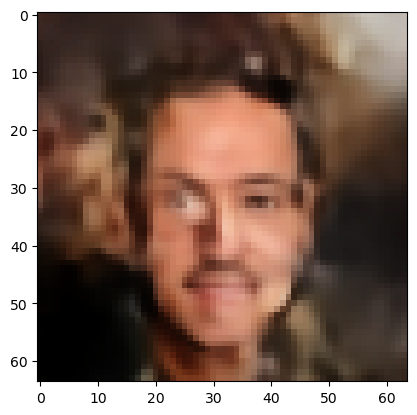

In [30]:
def show_images(model):
    model.eval()
    with torch.no_grad():
            z = torch.randn((1, 512, 2, 2)).to(device)
            gen_img, _ = model.decoder(z)
            gen_img = gen_img.permute(0, 2, 3, 1)
            gen_img = gen_img[0].cpu().numpy() * 255
            gen_img = gen_img.astype(np.uint8)

            plt.imshow(gen_img)
            plt.show()
            
show_images(model)
# print(f'Loss: {loss.item():.4f}')